# Basic stats 

In this section we look further into some key properties of our network. Following our data collection we create an edgelist with all the wikipedia pages' hyperlinks and a `Pandas DataFrame` that contain additional data: the discipline of the page, the text of the page and its categories. To begin the inspection of our data we create a directed network, where each wikipeda page is a node and the hyperlink to other pages serves as edges.

In [1]:
import pickle
import networkx as nx
import pandas as pd
import powerlaw
from fa2 import ForceAtlas2
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt

from pyvis.network import Network
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

In [2]:
# We load our files see data_collection.ipynb for further information
edgelist = pd.read_pickle("https://drive.google.com/uc?export=download&id=1x1WOVm5Wp6SLfN1sePSdgorbAaGQSYR3")
df = pd.read_pickle("https://drive.google.com/uc?export=download&id=1kBYnRUKQ0vkE-nc1Pf91b9a7wKjZ3Zp3")

In [3]:
edgelist = [e for e in edgelist if e[0] != e[1]]
G = nx.DiGraph()
G.add_edges_from(edgelist)
gcc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(gcc)
print(f"The directed network has: {len(G.nodes())} nodes and {len(G.edges())} edges.")

The directed network has: 4164 nodes and 20012 edges.


Despite our effort to reduce the size of network by restricting it to only contain weekly component nodes as minimum ($k_{in}$ or $k_{out}$ > 1) it still yields quite a large network. This is due to the choice of our data collection strategy and the structure of wikiepdia where a lot pages might have several categorisations. To put out network under further scrutiny it is relevant to compute the in- and out-degree distributions.

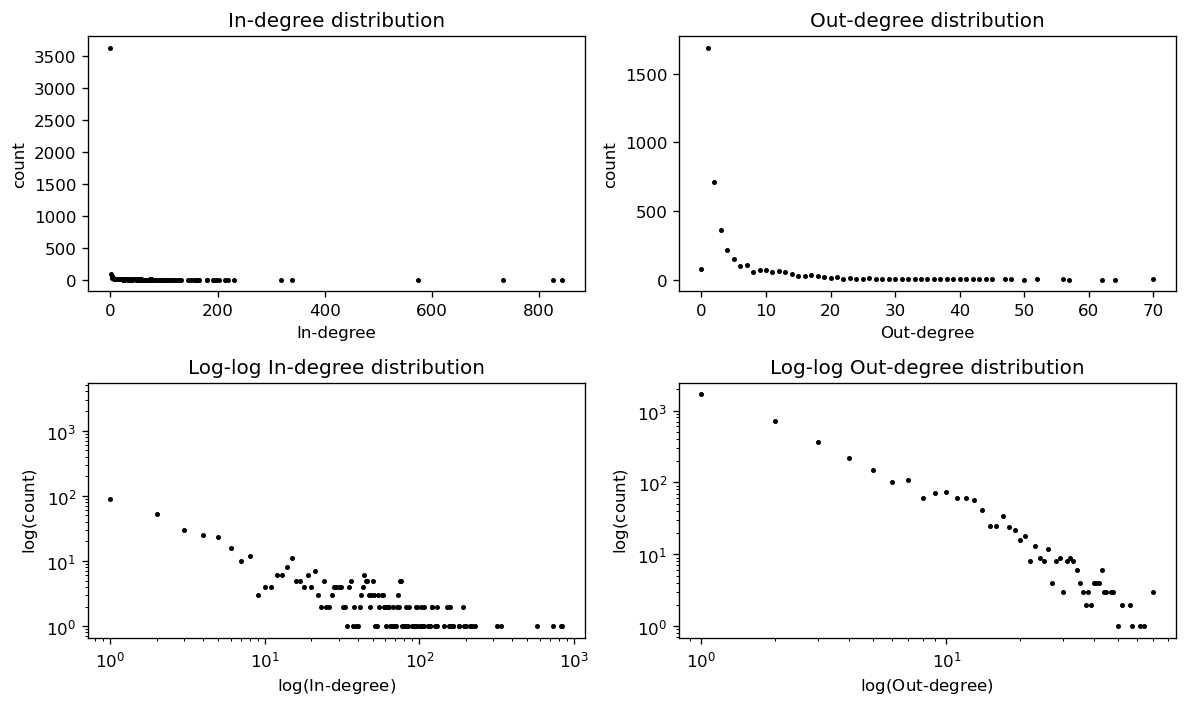

In [4]:
def get_degree_distributions(G: nx.DiGraph, degree: str="In") -> list:
        """
        Takes a graph as input and returns a list, x, that contains the different degrees,
        and an additional list, y, that contains the count of the corresponding counts.
        """
        if degree=="In":
            count = Counter([i[1] for i in list(G.in_degree())])
        elif degree=="Out":
            count = Counter([i[1] for i in list(G.out_degree())])
        count = sorted(count.items())
        x = [i[0] for i in count]
        y = [i[1] for i in count]
        return x, y

def draw_degree_distributions(G: nx.DiGraph):
    """
    Draws four plots (two log-log and two linear) based on a directed graph's
    in-degree and out-degree distributions. 
    """

    fig, axs = plt.subplots(2, 2, dpi = 120, figsize = (10,6))
    for i in range(2):
        for j, d in enumerate(["In", "Out"]):
            x, y = get_degree_distributions(G, degree = d)

            # for linear plots
            axs[i][j].plot(x, y, 'ko', markersize=2)
            axs[i][j].set_yticks(range(0, max(y)+250, 500))
            axs[i][j].set_ylabel('count')
            axs[i][j].set_xlabel(f'{d}-degree')
            axs[i][j].set_title(f'{d}-degree distribution')

            # for log-log-plots
            if i == 1:
                axs[i][j].loglog()
                axs[i][j].set_ylabel('$\log($count$)$')
                axs[i][j].set_xlabel(f'$\log(${d}-degree$)$')
                axs[i][j].set_title(f'Log-log {d}-degree distribution')

    plt.tight_layout()

draw_degree_distributions(G)

When comparing the linear plots with the log-log plot, it is clear that our directed network have scale-free properties. The reason for this is that the degree distriubtion is well approximated by a linear model on a log-log scale suggesting that the degree distribution follows a power-law distribution (Barabási 2016). Formally the pow-law distribution can be expressed as: 

$Pk \sim$ $k^{-\gamma}$

where $P_k$ is the probability that a random node links to another node, and $k$ is the degree exponent (Barabási 2016). If we rewrite the expression to $Pk_{out} \sim$ $k^{-\gamma_{out}}$ and $Pk_{in} \sim$ $k^{-\gamma_{in}}$ we can calculate the exponent for both of the distributions.

In [5]:
%%capture
# We extract the the exponent
in_degree_dist = [i[1] for i in G.in_degree()]
out_degree_dist = [i[1] for i in G.out_degree()]
in_degree_exp = powerlaw.Fit(in_degree_dist)
out_degree_exp = powerlaw.Fit(out_degree_dist)

In [6]:
print("The exponent of the In-degree distribution is: {}"\
      .format(in_degree_exp.power_law.alpha))
print("The exponent of the Out-degree distribution is: {}"\
      .format(out_degree_exp.power_law.alpha))

The exponent of the In-degree distribution is: 2.769914588125569
The exponent of the Out-degree distribution is: 7.065090437619653


As the exponent corresponds to the slope of the straight line in a log-log plot, this means that the out-degree distrubution to a larger degree than the in-degree distrubitions is scale-free. So what does all of this entail in practice? Not surprinsgly for a collection of web documents, this suggests, that a few pages with alot of links are dominating the network. Let us inspect some these pages.

<ipython-input-7-337b7b5bfea7>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels(x, rotation = 90)


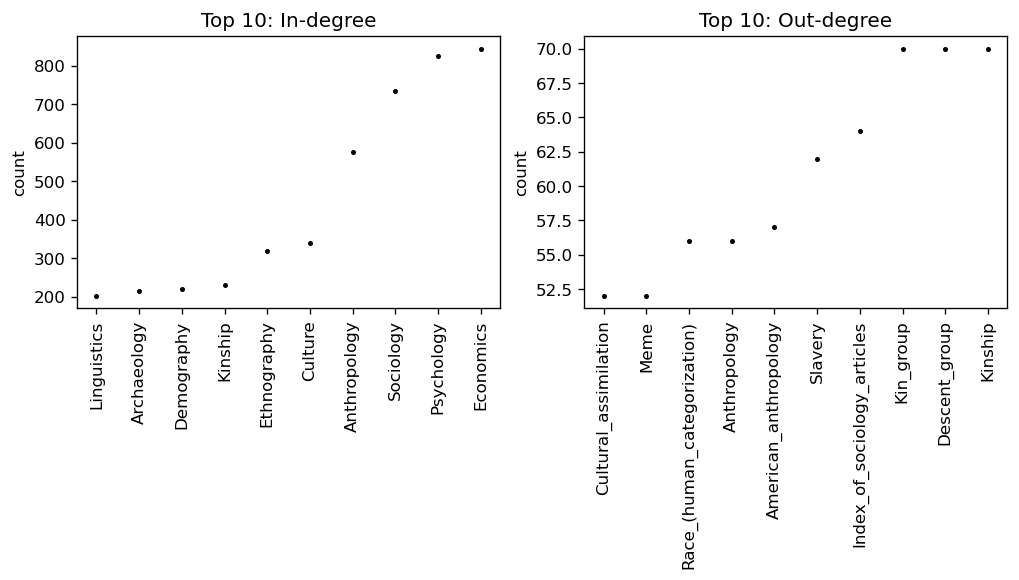

In [7]:
def get_high_k_nodes(G: nx.DiGraph, degree: str="In", n: int=10):
    """
    Function to get the name of nodes with a high k and their corresponding k
    """
    if degree=="In":
        degree_list = sorted(G.in_degree(), key=lambda tup: tup[1], reverse=True)[0:n]
    elif degree=="Out":
        degree_list = sorted(G.out_degree(), key=lambda tup: tup[1], reverse=True)[0:n]
    x = [i[0] for i in degree_list]
    y = [i[1] for i in degree_list]
    x.reverse()
    y.reverse()
    return x, y

def draw_high_k_nodes(G: nx.DiGraph):
    """
    Draws two plots based on nodes in a network with a high in-degree and out-degree.
    """

    fig, axs = plt.subplots(ncols=2, dpi = 120, figsize = (10,3))
    for j, d in enumerate(["In", "Out"]):
        x, y = get_high_k_nodes(G, degree = d)
        axs[j].plot(x, y, 'ko', markersize=2)
        axs[j].set_ylabel('count')
        axs[j].set_xticklabels(x, rotation = 90)
        axs[j].set_title(f'Top 10: {d}-degree')

draw_high_k_nodes(G)

The inspection of the pages with high degrees reveal, that the keyword used for categorisation (Anthropology, Economicis, Sociology, Psycology and Political science) also have independent wikipedia pages. Naturally, a large share of the other pages refers to these, why four out of five discipline's wikipedia page are among the pages with a highest in-degree. Given how much they distort our network we do not believe it is meaningful to keep them in our network. Likewise we also remove pages with "Index_of_" in the name.

In [8]:
social_sciences = ["Anthropology", "Economics", "Sociology", "Psychology", "Political_science"]
index_of = [n for n in G.nodes() if "Index_of_" in n]
elements_to_remove = social_sciences + index_of
new_edgelist = [e for e in edgelist if (e[0] not in elements_to_remove) and (e[1] not in elements_to_remove)]

G = nx.DiGraph()
G.add_edges_from(new_edgelist)
print(f"The new directed network has: {len(G.nodes())} nodes and {len(G.edges())} edges.")

The new directed network has: 3113 nodes and 16796 edges.


In [ ]:
draw_degree_distributions(G)

In [ ]:
draw_high_k_nodes(G)

In order to enhance readability of our plot we extract the giant connected component and turn the directed network into an undirected network. We furthermore specify Force Atlas 2 as our layout algorithm, set node sizes according to degree and colour according to discipline.

In [9]:
G = nx.DiGraph.to_undirected(G)
gcc = max(nx.connected_components(G), key=len)
G = G.subgraph(gcc)

In [10]:
forceatlas2 = ForceAtlas2(gravity=1)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)

100%|██████████| 1000/1000 [00:55<00:00, 17.92it/s]

BarnesHut Approximation  took  17.09  seconds
Repulsion forces  took  35.87  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  0.27  seconds
AdjustSpeedAndApplyForces step  took  0.88  seconds


In [11]:
def node_colour(node, df = df):
    if df.loc[df["name"] == node]["parent"].values[0] == "political_science":
        return "lightblue" 
    elif df.loc[df["name"] == node]["parent"].values[0] == "economics":
        return "lightgreen"
    elif df.loc[df["name"] == node]["parent"].values[0] == "anthropology":
        return "lightgrey"
    elif df.loc[df["name"] == node]["parent"].values[0] == "psychology":
        return "yellow"
    elif df.loc[df["name"] == node]["parent"].values[0] == "sociology":
        return "brown"
    
node_colour = [node_colour(node) for node in tqdm(G.nodes)]
node_sizes = [G.degree(node) * 0.25 for node in tqdm(G.nodes())]

  0%|          | 0/3055 [00:00<?, ?it/s]

  0%|          | 0/3055 [00:00<?, ?it/s]

In [12]:
output_notebook()
title = 'Out network!'

#Create a plot — set dimensions, toolbar, and title
HOVER_TOOLTIPS = [("Page", "@index")]
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              x_range=Range1d(-1000, 1000),
              y_range=Range1d(-1000, 1000), 
              title=title)

G_interactive = from_networkx(G, positions, scale=1, center=(0, 0))
G_interactive.node_renderer.data_source.data['node_sizes'] = node_sizes
G_interactive.node_renderer.data_source.data['node_colour'] = node_colour

#Set node size and color
G_interactive.node_renderer.glyph = Circle(
    size="node_sizes",
    fill_color="node_colour"
)

#Set edge opacity and width
G_interactive.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=0.1)

plot.renderers.append(G_interactive)
show(plot)

Loading BokehJS ...